In [15]:
import os
import timeit
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from collections import defaultdict
from collections import Counter
from random import shuffle
from scipy import signal
from scipy import fftpack
from scipy.io import wavfile
from scipy import interpolate 

import pandas as pd

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
!ls train
!ls train/one

one  two
ch1  ch2  ch3  ch4  ch5  ch6  ch7  ch8


### Set variables

In [4]:
train_paths = ['train', 'train_2','train_3']
test_path = 'test_data'
label_paths = ['one', 'two']
channel_paths = ['ch1', 'ch2', 'ch3', 'ch4']

enum_labels = {'one': 0, 'two': 1}

### Set global variables

In [5]:
TFR_TRAIN = 'train.tfrecord'
TFR_VALID = 'valid.tfrecord'
TFR_TEST = 'test.tfrecord'
BUCKET = 'gs://robolab/'

NUM_CLASSES = 2

IMG_HEIGHT = 160
IMG_WIDTH = 113
IMG_CHAN = 4

SPEC_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHAN)

### Log spectrogram function

In [6]:
# nperseg - samples per segment
# noverlap - number of overlapping samples
# high nperseg results in high frequency resolution, but low time resolution, and vice versa

def log_spectrogram(wav,
                    sample_rate=8000,
                    crop=None,
                    nfft=None,
                    nperseg=128,
                    noverlap=None,
                    eps=1e-10,
                    spec_only=True):
    
    # remove DC offset
    wav = wav - np.mean(wav)
    
    # normalize length
    wav = crop_and_pad(wav, sample_rate)
    
    freqs, times, spectro = signal.spectrogram(wav,
                                               fs=sample_rate,
                                               window='hann',
                                               noverlap=noverlap,
                                               nperseg=nperseg,
                                               nfft=None,
                                               detrend=False)
    
    if spec_only:
        return np.log(spectro.astype(np.float32) + eps)
    else:
        return freqs, times, np.log(spectro.astype(np.float32) + eps)

### Wavelet length normalizer

In [7]:
# crop if longer, pad if shorter than sampling frequency (fs)

def crop_and_pad(wav, fs):
    
    if len(wav) < fs:

        pad_front = (fs - len(wav)) // 2
        pad_end = (fs - len(wav)) - pad_front

        wav = np.concatenate(
            (np.random.rand(pad_front,) * 10, wav, np.random.rand(pad_end,) * 10), axis=0)

    elif len(wav) > fs:
        wav = wav[:fs]
        
    return wav

### Phase spectrogram function

In [8]:
# get phase spectrogram

def phase_spectrogram(wav,
                    sample_rate=8000,
                    crop=None,
                    nfft=None,
                    nperseg=128,
                    noverlap=None,
                    eps=1e-10,
                    spec_only=True):
    
    # remove DC
    wav = wav - np.mean(wav)
    
    # normalize length
    wav = crop_and_pad(wav, sample_rate)
    
    freqs, times, spectro = signal.spectrogram(wav,
                                               fs=sample_rate,
                                               window='hann',
                                               noverlap=noverlap,
                                               nperseg=nperseg,
                                               mode='phase', # get phase spectogram
                                               nfft=None,
                                               detrend=False)
    
    if spec_only:
        return spectro.astype(np.float32)
    else:
        return freqs, times, spectro.astype(np.float32)

### Angle spectrogram

In [9]:
# get angle spectrogram

def angle_spectrogram(wav,
                    sample_rate=8000,
                    crop=None,
                    nfft=None,
                    nperseg=128,
                    noverlap=None,
                    eps=1e-10,
                    spec_only=True):
    
    # remove DC
    wav = wav - np.mean(wav)
    
    # normalize length
    wav = crop_and_pad(wav, sample_rate)
    
    freqs, times, spectro = signal.spectrogram(wav,
                                               fs=sample_rate,
                                               window='hann',
                                               noverlap=noverlap,
                                               nperseg=nperseg,
                                               mode='angle', # get angle spectogram
                                               nfft=None,
                                               detrend=False)
    
    if spec_only:
        return spectro.astype(np.float32)
    else:
        return freqs, times, spectro.astype(np.float32)

### Multi spectrogram function

In [10]:
# This function creates 3D array, containing:
# 1 - high frequency resolution spectrogram
# 2 - high time resolution srectrogram
# 3 - phase spectrogram

def multi_spectrogram(wav, fs):

    spec = log_spectrogram(wav, sample_rate=fs, nperseg=80) # shape=(41, 114)
    spec = spec / np.max(abs(spec))

    spec_2 = log_spectrogram(wav, sample_rate=fs, nperseg=224) # shape=(113, 40)
    spec_2 = spec_2 / np.max(abs(spec_2))

    spec_3 = phase_spectrogram(wav, sample_rate=fs, nperseg=80) # shape=(41, 114)
    spec_3 = spec_3 / np.max(abs(spec_3))
    
    spec_4 = angle_spectrogram(wav, sample_rate=fs, nperseg=80) # shape=(41, 114)
    spec_4 = spec_4 / np.max(abs(spec_4))

    # specs are not 100% equal in size, so crop them if needed, and then stack
    spec_all_chan = np.stack([spec[:40,:113], spec_2.T, spec_3[:40,:113], spec_4[:40,:113]], axis=2)
    
    return spec_all_chan

### Spectrogram examples

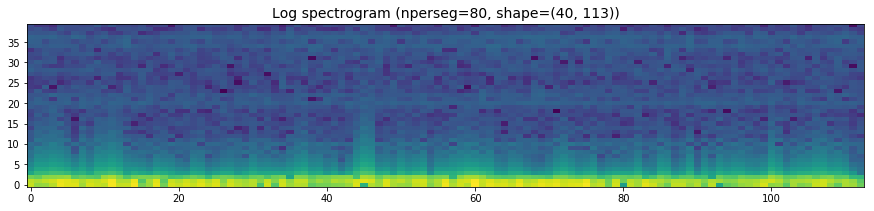

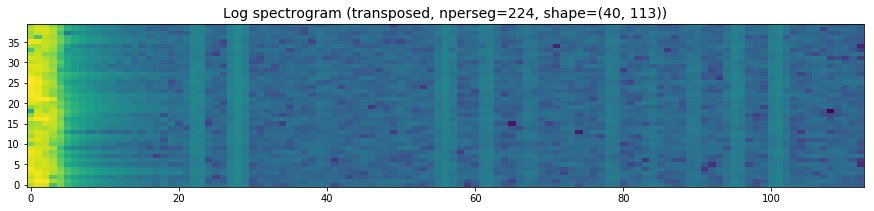

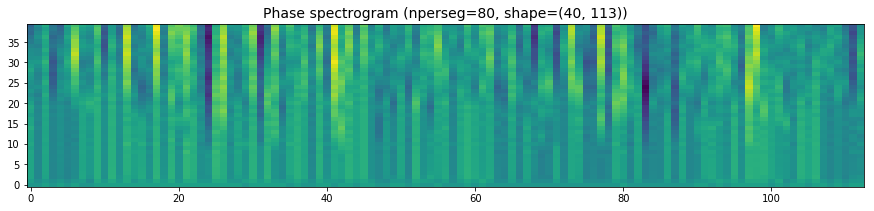

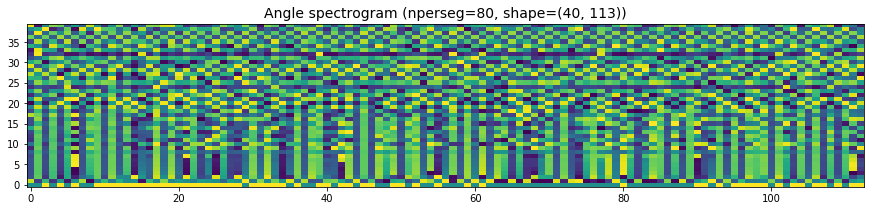

In [11]:
file = 'train/one/ch1/00961.wav'
fs, wav = wavfile.read(file)

multi_spec = multi_spectrogram(wav, fs)

plt.figure(figsize=(15, 3))
plt.title('Log spectrogram (nperseg=80, shape={})'.format(multi_spec[:,:,0].shape), fontsize=14)
plt.imshow(multi_spec[:,:,0], origin='lower', aspect='auto')
plt.show()

plt.figure(figsize=(15, 3))
plt.title('Log spectrogram (transposed, nperseg=224, shape={})'.format(multi_spec[:,:,1].shape), fontsize=14)
plt.imshow(multi_spec[:,:,1], origin='lower', aspect='auto')
plt.show()

plt.figure(figsize=(15, 3))
plt.title('Phase spectrogram (nperseg=80, shape={})'.format(multi_spec[:,:,2].shape), fontsize=14)
plt.imshow(multi_spec[:,:,2], origin='lower', aspect='auto')
plt.show()

plt.figure(figsize=(15, 3))
plt.title('Angle spectrogram (nperseg=80, shape={})'.format(multi_spec[:,:,3].shape), fontsize=14)
plt.imshow(multi_spec[:,:,3], origin='lower', aspect='auto')
plt.show()

### Get dictionary of label to filepaths

In [12]:
# train_list[label] = [ { file_name: file_path_1, file_path_2, ... }, ... ]

train_list = defaultdict(list)

for path in train_paths:
    
    for label in label_paths:
        
        train_dict = defaultdict(list)
        
        for channel in channel_paths:
            
            for file in os.listdir(os.path.join(path, label, channel)):
                
                train_dict[file].append(os.path.join(path, label, channel, file))
                
        train_list[label].append(train_dict)

### Get 4-channel file lists and corresponding labels

In [13]:
# files = [ [ ch1, ch2, ch3, ch4 ], ... ]
# labels = [ label_1, label_2, ... ]

files = []
labels = []
corrupt_files = 0

for label in train_list:
    
    for dictionary in train_list[label]:
        
        for file_name in dictionary:
            
            # get list of filepaths and filesizes for all 4 channels
            sizes = []
            paths = []
            
            for file_path in dictionary[file_name]:
                if 'wav' in file_path:
                    size = os.stat(file_path).st_size
                    sizes.append(size)
                    paths.append(file_path)
            
            # skip filepath-list if file is missing or sample too short
            if len(sizes) == 4 and min(sizes) >= 12114:
                files.append(paths)
                labels.append(label)
            else:
                corrupt_files += 1
                
print('Corrupted data:', corrupt_files)

Corrupted data: 4


### Get filepaths for data to augment

In [14]:
# not used for now

files_to_augment = []
labels_for_augment = []

for file_list in files:

    paths = []
    sizes = []
    label = file_list[0].split(sep='/')[1]
    
    for file in file_list:
        
        sizes.append(os.stat(file).st_size)
        paths.append(file)
    
    if min(sizes) > 16114 and len(set(sizes)) == 1:
        labels_for_augment.append([label, sizes[0]])
        files_to_augment.append(paths)
    
print('Samples to augment:', len(files_to_augment))

Samples to augment: 4756


### Shuffle and split path lists

In [15]:
RATIO = 0.9

size = round(RATIO * len(files))

shuff_files = []
shuff_labels = []
index_shuf = list(range(len(files)))

shuffle(index_shuf)

for i in index_shuf:
    shuff_files.append(files[i])
    shuff_labels.append(labels[i])
    
train_files = shuff_files[:size]
valid_files = shuff_files[size:]

train_labels = shuff_labels[:size]
valid_labels = shuff_labels[size:]

print('{:<25}{}'.format('Train samples', len(train_files)))
print('{:<25}{}'.format('Train labels', len(train_labels)))

print('{:<25}{}'.format('Validation samples', len(valid_files)))
print('{:<25}{}'.format('Validation labels', len(valid_labels)))

Train samples            4606
Train labels             4606
Validation samples       512
Validation labels        512


### Bytes feature function

In [16]:
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

### Create train tfrecord

In [17]:
# read files, create spectograms and enumerated labels, convert them to bytes and write to TF-record file

writer = tf.python_io.TFRecordWriter(BUCKET + TFR_TRAIN)

for files, label in zip(train_files, train_labels):
    
    multi_specs = []
    
    for file in files:

        fs, wav = wavfile.read(file)
        multi_spec = multi_spectrogram(wav, fs)
        multi_specs.append(multi_spec)

    stacked_multi_spec = np.concatenate(multi_specs, axis=0)
    np_label = np.asarray([enum_labels[label]], dtype=np.int32)
    
    assert stacked_multi_spec.shape == SPEC_SHAPE, \
    'Wrong spectogram shape: expected {}, got {}'.format(SPEC_SHAPE, stacked_multi_spec.shape)

    arr_raw = stacked_multi_spec.tostring()
    label_raw = np_label.tostring()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image_raw': bytes_feature(arr_raw),
        'label': bytes_feature(label_raw)}))

    writer.write(example.SerializeToString())

writer.close()

### Create validation tfrecord

In [18]:
writer = tf.python_io.TFRecordWriter(BUCKET + TFR_VALID)

for files, label in zip(valid_files, valid_labels):
    
    multi_specs = []
    
    for file in files:

        fs, wav = wavfile.read(file)
        multi_spec = multi_spectrogram(wav, fs)
        multi_specs.append(multi_spec)

    stacked_multi_spec = np.concatenate(multi_specs, axis=0)
    np_label = np.asarray([enum_labels[label]], dtype=np.int32)
    
    assert stacked_multi_spec.shape == SPEC_SHAPE, \
    'Wrong spectogram shape: expected {}, got {}'.format(SPEC_SHAPE, stacked_multi_spec.shape)

    arr_raw = stacked_multi_spec.tostring()
    label_raw = np_label.tostring()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image_raw': bytes_feature(arr_raw),
        'label': bytes_feature(label_raw)}))

    writer.write(example.SerializeToString())

writer.close()

### TF-Record parsers

In [19]:
def parser(serialized_example):

    features = tf.parse_single_example(
        serialized_example,
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.string)})

    image = tf.decode_raw(features['image_raw'], tf.float32)
    image.set_shape([IMG_HEIGHT * IMG_WIDTH * IMG_CHAN])

    label = tf.decode_raw(features['label'], tf.int32)
    label.set_shape([1])

    return image, label

In [20]:
def test_parser(serialized_example):

    features = tf.parse_single_example(
        serialized_example,
        features={'image_raw': tf.FixedLenFeature([], tf.string),
                  'image_id': tf.FixedLenFeature([], tf.string)})

    image = tf.decode_raw(features['image_raw'], tf.float32)
    image.set_shape([IMG_HEIGHT * IMG_WIDTH * IMG_CHAN])

    return image

### Input functions

In [21]:
def train_input_fn():

    # get dataset from tf_record
    dataset = tf.data.TFRecordDataset(BUCKET + TFR_TRAIN)

    # map parser over dataset samples
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat(1)
    iterator = dataset.make_one_shot_iterator()

    features, labels = iterator.get_next()

    return features, labels

In [22]:
def eval_input_fn():

    # get dataset from tf_record
    dataset = tf.data.TFRecordDataset(BUCKET + TFR_TRAIN)

    # map parser over dataset samples
    dataset = dataset.map(parser)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat(1)
    iterator = dataset.make_one_shot_iterator()

    features, labels = iterator.get_next()

    return features, labels

In [23]:
def valid_input_fn():

    # get dataset from tf_record
    dataset = tf.data.TFRecordDataset(BUCKET + TFR_VALID)

    # map parser over dataset samples
    dataset = dataset.map(parser)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat(1)
    iterator = dataset.make_one_shot_iterator()

    features, labels = iterator.get_next()

    return features, labels

In [24]:
def predict_input_fn():

    # get dataset from tf_record
    dataset = tf.data.TFRecordDataset(BUCKET + TFR_TEST)

    # map parser over dataset samples
    dataset = dataset.map(test_parser)
    dataset = dataset.batch(1)
    dataset = dataset.repeat(1)
    iterator = dataset.make_one_shot_iterator()

    features = iterator.get_next()

    return features

### CNN model

#### CNN branch

In [25]:
# convolve through each layer separately

def cnn_branch(in_1, in_2, in_3, in_4, is_train):
    
    # define arguments for layers
    kerner_init = None
    
    conv_params_1 = {
        'filters': 8,
        'kernel_size': [5, 3],
        'strides': 1,
        'kernel_initializer': kerner_init,
        'padding': 'same'}
    
    conv_params_2 = {
        'filters': 32,
        'kernel_size': [3, 3],
        'strides': 1,
        'kernel_initializer': kerner_init,
        'padding': 'same',
        'activation': tf.nn.relu}
    
    conv_params_3 = {
        'filters': 64,
        'kernel_size': [3, 3],
        'strides': 1,
        'kernel_initializer': kerner_init,
        'padding': 'same',
        'activation': tf.nn.relu}
    
    pool_params = {
        'pool_size': [2, 2],
        'strides': [2, 2],
        'padding': 'same'}
    
    dense_params_1 = {
        'units': 512,
        'activation': tf.nn.relu}
    
    dense_params_2 = {
        'units': 128,
        'activation': tf.nn.relu}
    
    w_1a = tf.Variable(0.25)
    w_1b = tf.Variable(0.25)
    w_1c = tf.Variable(0.25)
    w_1d = tf.Variable(0.25)
    
    # define layers
    conv_1a = tf.layers.conv2d(inputs=in_1, **conv_params_1)
    conv_1b = tf.layers.conv2d(inputs=in_2, **conv_params_1)
    conv_1c = tf.layers.conv2d(inputs=in_3, **conv_params_1)
    conv_1d = tf.layers.conv2d(inputs=in_4, **conv_params_1)
    
    pool_1a = tf.layers.max_pooling2d(inputs=conv_1a, **pool_params)
    pool_1b = tf.layers.max_pooling2d(inputs=conv_1b, **pool_params)
    pool_1c = tf.layers.max_pooling2d(inputs=conv_1c, **pool_params)
    pool_1d = tf.layers.max_pooling2d(inputs=conv_1d, **pool_params)
    
    mix_1 = tf.add_n([pool_1a * w_1a,
                      pool_1b * w_1b,
                      pool_1c * w_1c,
                      pool_1d * w_1d])
    
    conv_2 = tf.layers.conv2d(inputs=mix_1, **conv_params_2)
    pool_2 = tf.layers.max_pooling2d(inputs=conv_2, **pool_params)
    
    conv_3 = tf.layers.conv2d(inputs=pool_2, **conv_params_3)
    pool_3 = tf.layers.max_pooling2d(inputs=conv_3, **pool_params)
    
    dropout = tf.layers.dropout(inputs=pool_3, rate=0.2, training=is_train)
    
    reshape = tf.layers.flatten(dropout)

    dense = tf.layers.dense(inputs=reshape, **dense_params_1)
    dense_2 = tf.layers.dense(inputs=dense, **dense_params_2)

    out = tf.layers.dense(inputs=dense_2, units=NUM_CLASSES)
    
    return out

#### CNN main

In [26]:
# split image by channels to convolve through these channels separately

def cnn_model_fn(features, labels, mode):
        
    is_train = False
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_train = True
    
    # reshape flat input to original image shape and split image by layers
    input_layer = tf.reshape(features, [-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHAN], name='inputs')
    in_1, in_2, in_3, in_4 = tf.split(input_layer, num_or_size_splits=4, axis=3)
    
    # get tensor with shape=(batch_size, NUM_CLASSES)
    out = cnn_branch(in_1, in_2, in_3, in_4, is_train)
    
    logits = tf.nn.softmax(out, axis=1)
    
    # in predict mode, also return logits per layer
    predictions = {
        'classes': tf.argmax(logits, axis=1),
        'probabilities': logits}

    # for Cloud ML serving model
    serving_output = tf.estimator.export.ClassificationOutput(scores=predictions['probabilities'])
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=predictions,
                                          export_outputs={'output': serving_output})

    # calculate loss and acc
    loss = tf.losses.sparse_softmax_cross_entropy(
        labels=labels,
        logits=logits)
    
    acc = tf.metrics.accuracy(
        labels=labels,
        predictions=tf.argmax(logits, axis=1))

    if mode == tf.estimator.ModeKeys.TRAIN:
        
        train_optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)

    # eval mode
    eval_metric_ops = {'acc': acc}

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Train function

In [27]:
def train_and_evaluate(estimator, epochs=1):

    all_train_log = []
    all_valid_log = []

    for epoch in range(epochs):

        estimator.train(input_fn=train_input_fn)

        train_log = estimator.evaluate(input_fn=eval_input_fn)
        print('epoch: {} of {}'.format(epoch + 1, epochs))
        print('train: acc = {:.3f}, loss = {:.3f}'.format(train_log['acc'], train_log['loss']))
        
        valid_log = estimator.evaluate(input_fn=valid_input_fn)
        print('valid: acc = {:.3f}, loss = {:.3f}'.format(valid_log['acc'], valid_log['loss']))
        
        all_train_log.append(train_log)
        all_valid_log.append(valid_log)

    return all_train_log, all_valid_log

### Classifier

In [36]:
OUTDIR = BUCKET + 'output_for_testing_12'
BATCH_SIZE = 10
EPOCHS = 1
LR = 0.001

cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir=OUTDIR)

### Train

In [42]:
start = timeit.default_timer()

train_log, valid_log = train_and_evaluate(cnn_classifier, epochs=EPOCHS)

end = timeit.default_timer()
print('\nTime spent:', round((end - start) / 60) , 'min')

epoch: 1 of 1
train: acc = 0.956, loss = 0.356
valid: acc = 0.926, loss = 0.385

Time spent: 2 min


### Get test data

In [30]:
test_files = defaultdict(list)

for folder in os.listdir(test_path):
    for file in os.listdir(os.path.join(test_path, folder)):
        test_files[folder].append(os.path.join(test_path, folder, file))
    test_files[folder].sort()

### Create test tfrecord file

In [31]:
folder_labels = []

writer = tf.python_io.TFRecordWriter(BUCKET + TFR_TEST)

for folder in test_files:
    
    multi_specs = []
    
    for file in test_files[folder]:

        fs, wav = wavfile.read(file)
        multi_spec = multi_spectrogram(wav, fs)
        multi_specs.append(multi_spec)

    stacked_multi_spec = np.concatenate(multi_specs, axis=0)
    
    folder_labels.append(folder)
    
    assert stacked_multi_spec.shape == SPEC_SHAPE, \
    'Wrong spectogram shape: expected {}, got {}'.format(SPEC_SHAPE, stacked_multi_spec.shape)

    arr_raw = stacked_multi_spec.tostring()
    label_raw = bytes(folder, 'utf-8')

    example = tf.train.Example(features=tf.train.Features(feature={
        'image_raw': bytes_feature(arr_raw),
        'image_id': bytes_feature(label_raw)}))

    writer.write(example.SerializeToString())

writer.close()

### Predict

In [43]:
# get predictions: probs, predicted classes and list of 3 logit arrays

start = timeit.default_timer()

predict_generator = cnn_classifier.predict(input_fn=predict_input_fn)

predict_list = []
predict_dictlist = []

while True:
    item = next(predict_generator, None)
    if item == None:
        break
    predict_dictlist.append(item)
    
for i in range(len(predict_dictlist)):
    
    cur = predict_dictlist[i]
    
    prob = list(cur['probabilities'])
    class_ = cur['classes']
    
    predict_list.append((folder_labels[i], class_, prob))

end = timeit.default_timer()

print('Time spent:', round((end - start) / 60) , 'min')

Time spent: 0 min


### Explore predictions

In [44]:
# calculate number of cases where none of the logits is accurate (lower than 65%)

logits = [prob for (folder_label, class_, prob) in predict_list]

def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

low_probs = []

for logit in logits:
    if np.max(logit) < 0.65:
        low_probs.append(logit)
        
print('Low probs:', len(low_probs))

Low probs: 2


In [45]:
# calculate accuracy on test data (unknown data)

test_labels = pd.read_csv('test_key.csv')

test_ids = list(test_labels['fileName'])
test_classes = list(test_labels['label'])

test_class_dict = dict()

for img_id, label in zip(test_ids, test_classes):
    test_class_dict.update({img_id: label})

expect_labels = [test_class_dict[text] - 1 for text in folder_labels]
predict_classes = [class_ for (folder_label, class_, prob) in predict_list]

acc = np.sum(np.array(expect_labels) == np.array(predict_classes)) / len(predict_classes)

print('Accuracy on test data:\n')
print('overall_acc = {:.3f}'.format(acc))

Accuracy on test data:

overall_acc = 0.966


In [46]:
print('Max and min mean probs:\n')

mean_probs = [
    (max(prob) / len(logits), min(prob) / len(logits)) for prob in logits]
print('logit:', np.sum(mean_probs, axis=0))

Max and min mean probs:

logit: [0.99503648 0.00496352]
